In [73]:
import pandas as pd
import numpy as np
import sys
sys.path.append('../..')
from helper.lazy_regression import TooLazyForRegression
from helper.feature_extract import extract_highest_amplitude_features_with_mp
import xgboost as xgb
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
import shap

import time
import matplotlib.pyplot as plt

In [74]:
data = pd.read_table('../../data/data_spg.txt', sep=' ')
data = extract_highest_amplitude_features_with_mp(df=data, sensor_types=[['G01', 'G02']], create_one_sensor_feature=True, n_processes=4, keep_columns=False)

INFO || Extracting Max Features for types: ['G01', 'G02']


In [81]:
data_max = data.drop(['start_time'], axis=1)
X, y = data_max.drop(['size_mm'], axis=1), np.log(data_max['size_mm'])
y =y.astype(np.str)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state = 102)

In [83]:
start = time.time()
model= xgb.XGBRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("R2-Score:",r2_score(y_pred,y_test))
end = time.time()
print("Time:",end - start)

R2-Score: 0.833721206253053
Time: 1.362851858139038


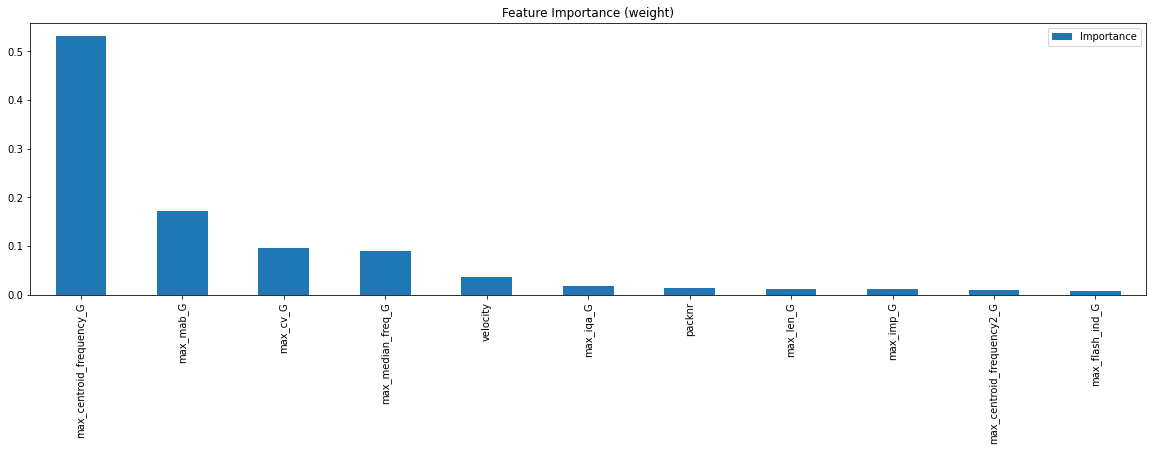

In [84]:
importances = dict(zip(data_max.drop('size_mm', axis=1).columns, model.feature_importances_)) 
importances = pd.DataFrame(data=importances.values(), columns=['Importance'], index=importances.keys())
importances.sort_values(by='Importance', ascending=False).head(30).plot(kind='bar', figsize=(20, 5), title='Feature Importance (weight)')
plt.show()

In [85]:
X.columns

Index(['packnr', 'velocity', 'max_centroid_frequency_G',
       'max_centroid_frequency2_G', 'max_median_freq_G', 'max_flash_ind_G',
       'max_cv_G', 'max_iqa_G', 'max_mab_G', 'max_imp_G', 'max_len_G'],
      dtype='object')

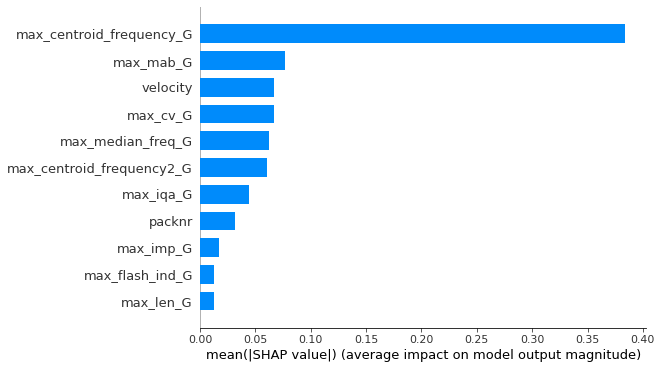

In [86]:
model= xgb.XGBRegressor()
model.fit(X, y)

shap_values = shap.Explainer(model).shap_values(X)
shap.summary_plot(shap_values, X, plot_type="bar")

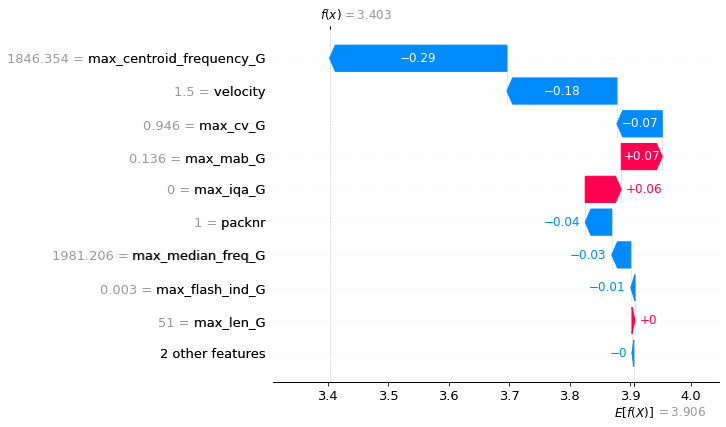

In [89]:
explainer = shap.Explainer(model)
shap_values = explainer(X)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

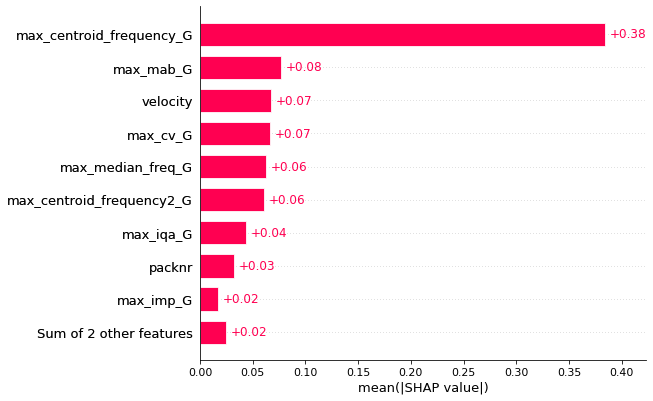

In [90]:
shap.plots.bar(shap_values)

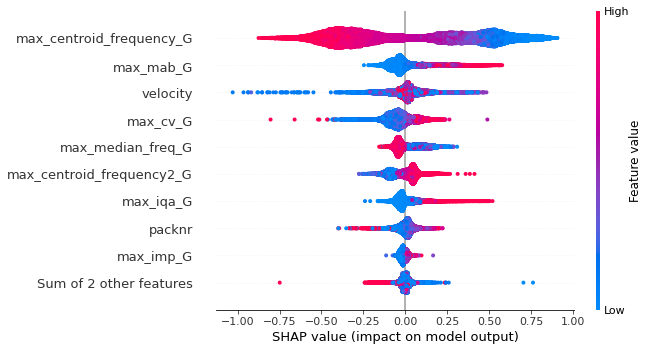

In [91]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values)